In [1]:
# -*- coding: utf-8 -*- 

import config

import os
import numpy as np
import pandas as pd

from pathlib import Path

from hbayesdm.models import ra_prospect

import nibabel as nib
# import nipype as nip
# import nilearn as nil

from bids import BIDSLayout
from tqdm import tqdm

import pickle
from sklearn import linear_model
from scipy.stats import zscore

from nltools.external import glover_hrf

In [2]:
layout = BIDSLayout(config.DATA_DIR, derivatives=True)
layout.add_derivatives(config.PREP_DIR)

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)
/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/bids/layout/layout.py:591: UserWarning: Derivative indexing was requested, but no valid datasets were found in the specified locations (['/home/mybirth0407/datasets/ds000005/derivatives']). Note that all BIDS-Derivatives datasets must meet all the requirements for BIDS-Raw datasets (a common problem is to fail to include a 'dataset_description.json' file in derivatives datasets).
Example contents of 'dataset_description.json':
{"Name": "Example dataset", "BIDSVersion": "1.0.2", "PipelineDescription": {"Name": "Example pipeline"}}
  json.dumps(EXAMPLE_DERIVATIVES_DESCRIP

In [3]:
layout

BIDS Layout: .../mybirth0407/datasets/ds000005 | Subjects: 16 | Sessions: 0 | Runs: 48

In [4]:
# make config
image_sample = nib.load(
    layout.derivatives['fMRIPrep'].get(
        subject=layout.get(target='subject', return_type='id')[0],
        return_type='file',
        suffix='bold',
        extension='nii.gz'
        )[0])
cfg = {
    'slicing_time': layout.get_tr(),
    'time_dim': image_sample.shape[3]
}
cfg['time_indices'] = [int(cfg['slicing_time'] * _t / config.RESPONSE_TR) for _t in range(cfg['time_dim'])]
cfg['affine'] = image_sample.affine

In [5]:
frmi_subject_run = {}
# simple structure for fmri_subject_run
# fmri_subject_run: {
#     subj: {
#         niis: [run1, run2, run3],
#         events: [run1, run2, run3]
#     }
# }

for subject_id in tqdm(layout.get(target='subject', return_type='id')):
    if subject_id not in frmi_subject_run.keys():
        frmi_subject_run[subject_id] = {
            'niis': layout.derivatives['fMRIPrep'].get(subject=subject_id, return_type='file', suffix='bold', extension='nii.gz'),
            'events': layout.get(subject=subject_id, return_type='file', suffix='events', extension='tsv')
        }
    else: # subjID is already exists..
        print(f'error! {subject_id}')
        break

100%|██████████| 16/16 [00:03<00:00,  4.82it/s]


In [6]:
df_all = []

for subject_id in layout.get(target='subject', return_type='id'):
    for i, df_path in enumerate(frmi_subject_run[subject_id]['events']):
        df = pd.read_table(df_path)
        df['subjID'] = int(subject_id)
        df['run'] = i + 1
        df_all.append(df)
    
df_all = pd.concat(df_all)

In [7]:
columns = df_all.columns.copy()

In [8]:
df_all = df_all[df_all['respcat'] != -1]
df_all['onset'] = df_all['onset'].astype(np.int)
df_all['cert'] = 0 # certain..?
df_all['gamble'] = df_all['respcat']
df_all.head()

INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,onset,duration,parametric loss,distance from indifference,parametric gain,gain,loss,PTval,respnum,respcat,response_time,subjID,run,cert,gamble
1,4,3,-0.0227,-0.4147,-0.189,18,12,6.12,2,1,1.793,1,1,0,1
2,8,3,0.1273,0.2519,-0.389,10,15,-4.85,3,0,1.637,1,1,0,0
3,18,3,0.1773,-0.0814,0.211,34,16,18.16,1,1,1.316,1,1,0,1
4,24,3,-0.3727,-0.0814,-0.189,18,5,13.05,1,1,1.670,1,1,0,1
5,28,3,0.0273,-0.4147,0.011,26,13,13.13,2,1,1.232,1,1,0,1


In [9]:
model = ra_prospect(data=df_all, ncore=4)
print(model.all_ind_pars)
params = model.all_ind_pars
params.to_csv('models/ra_prospect_params.tsv', sep='\t', index=False)

Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl



Model  = ra_prospect
Data   = <pandas.DataFrame object>

Details:
 # of chains                    = 4
 # of cores used                = 4
 # of MCMC samples (per chain)  = 4000
 # of burn-in samples           = 1000
 # of subjects                  = 16
 # of (max) trials per subject  = 256

Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl
Index(['onset', 'duration', 'parametric loss', 'distance from indifference',
       'parametric gain', 'gain', 'loss', 'ptval', 'respnum', 'respcat',
       'responsetime', 'subjid', 'run', 'cert', 'gamble'],
      dtype='object')
['onset', 'duration', 'parametric loss', 'distance from indifference', 'parametric gain', 'gain', 'loss', 'PTval', 'respnum', 'respcat', 'response_time', 'subjID', 'run', 'cert', 'gamble']
************************************
**** Model fitting is complete! ****
************************************
         rho    lambda        tau
1   0.450843  1.020849  17.716767
2   0.355433  1.446935  17.809101
3   0.29490

In [11]:
params = pd.read_csv('models/ra_prospect_params.tsv', sep='\t')
params['subjID'] = params.index + 1

In [12]:
params.head()

,rho,lambda,tau,subjID
0,0.450843,1.020849,17.716767,1
1,0.355433,1.446935,17.809101,2
2,0.294903,1.420133,17.338361,3
3,0.291512,1.397379,17.448340,4
4,0.233100,1.234434,16.921564,5


In [19]:
try: 
    df_X = pd.merge(df_all, params, how='left', on=['subjID'])
except:
    df_all.columns = columns
    df_X = pd.merge(df_all, params, how='left', on=['subjID'])

df_X['U_risky'] = (df_X['gain'] ** df_X['rho']) - (df_X['lambda'] * (df_X['loss'] ** df_X['rho']))

In [14]:
def data2bold(utilities, time_stamp, time_resolution=0.01, hrf=glover_hrf(0.01, oversampling=1)):
    assert len(utilities) == len(time_stamp)
    
    output = np.zeros(int((time_stamp.max()+30) / time_resolution))
    
    # make data impulse
    for time, value in zip(time_stamp, utilities):
        output[int(time/time_resolution)] = value
        
    # hrf convolution
    return output, np.convolve(output, hrf, mode='same')

In [20]:
latent_process = {}
latent_process_name = 'U_risky'

for name, group in tqdm(df_X.groupby(['subjID', 'run'])):
    subject_id, run = name[0], name[1]
    
    impulse, bold = data2bold(
        group[latent_process_name ].to_numpy(),
        group['onset'].to_numpy(),
        config.RESPONSE_TR
    )
    name = f'{subject_id:02d}-{run}'
    latent_process[name] = {}
    latent_process[name][f'{latent_process_name}_impluse'] = impulse
    latent_process[name][f'{latent_process_name}_bold'] = bold

100%|██████████| 48/48 [00:01<00:00, 26.12it/s]


In [22]:
run_list = layout.get(target='run', return_type='id')
subj_list = layout.get(target='subject', return_type='id')

In [24]:
train = {}
unit_time_length = int(layout.get_tr() / config.RESPONSE_TR)
for subjID in tqdm(frmi_subject_run):
    X, y = [] ,[]
    for runID in (run_list):
        _file_name = layout.derivatives['fMRIPrep'].get(subject=subjID,run=runID, return_type='file', suffix='bold', extension='nii.gz')[0]
        _img = nib.load(_file_name).get_fdata()
        time_length = _img.shape[-1]
        _name = f'{subjID}-{runID}'
        _x = latent_process[_name][f'{latent_process_name}_bold']
        _x_desired_length = len(_x)//unit_time_length
        _x = _x[:_x_desired_length*unit_time_length]
        final_length = min(time_length,_x_desired_length)
        _x = _x.reshape(-1,unit_time_length).mean(-1)[:final_length] 
        _img = _img[...,:final_length]
        X.append(np.array(_x))
        y.append(_img)
    train[subjID] = {'X':np.concatenate(X,-1),
                     'y':np.concatenate(y,-1)}

100%|██████████| 16/16 [01:26<00:00,  5.43s/it]


In [14]:
# no used

# df_utility_risky_bold = pd.DataFrame(columns=['subjID', 'run', 'onset', 'duration', 'U_risky'])

# for name, group in tqdm(df_X.groupby(['subjID', 'run'])):
#     subject_id, run = name[0], name[1]
    
#     utility_risky_bold = data2bold(
#         group['utility_risky'].to_numpy(),
#         group['onset'].to_numpy(),
#         config.RESPONSE_TR
#     )
    
#     utility_risky_bold_for_time = [
#         np.mean(utility_risky_bold[int(row['onset']) * 100: int(row['onset'] + row['duration']) * 100])
#             for i, row in group.iterrows()
#     ]
    
#     data = np.array([
#         [subject_id] * len(utility_risky_bold_for_time),
#         [run] * len(utility_risky_bold_for_time),
#         group['onset'].to_numpy(),
#         group['duration'].to_numpy(),
#         utility_risky_bold_for_time]
#     )
#     data = pd.DataFrame(data).T
#     data.columns=['subjID', 'run', 'onset', 'duration', 'utility_risky_bold']
#     df_utility_risky_bold = df_utility_risky_bold.append(data)
    
# df_utility_risky_bold['subjID'] = df_utility_risky_bold['subjID'].astype(int)
# df_utility_risky_bold['run'] = df_utility_risky_bold['run'].astype(int)

100%|██████████| 48/48 [00:02<00:00, 19.20it/s]


In [16]:
# no use

# train = {}

# for name0, group0 in tqdm(df_utility_risky_bold.groupby(['subjID'])):
#     X, y = [], []
    
#     for name1, group1 in group0.groupby(['run']):
#         subject_id, run = name0, name1
#         img =  nib.load(frmi_subject_run[f'{subject_id:02d}']['niis'][run-1]).get_fdata()

#         for i, row in group1.iterrows():
#             i = int(row['onset'] / 2)
#             j = int(i + row['duration'] / 2 + 1) # slicing
#             X.append(row['utility_risky_bold'])
#             y.append(np.mean(img[:,:,:,i:j], axis=3))

#     if f'{subject_id:02d}' not in train.keys():
#         train[f'{subject_id:02d}'] = {'X': np.array(X), 'y': np.array(y)}

100%|██████████| 16/16 [00:42<00:00,  2.64s/it]


In [26]:
from sklearn import linear_model

dict_coefs = {}

for key, value in tqdm(train.items()):
    X = value['X']
    y = value['y']
    coefs = []
    
    for i in range(y.shape[0]):
        i_v = []
        for j in range(y.shape[1]):
            j_v = []
            for k in range(y.shape[2]):
                reg = linear_model.LinearRegression().fit(X.reshape(-1, 1), y[i, j, k, :])
                j_v.append(np.array([float(reg.coef_), float(reg.intercept_)]))
            i_v.append(np.array(j_v))
        coefs.append(np.array(i_v))
    dict_coefs[key] = np.array(coefs)

100%|██████████| 16/16 [29:26<00:00, 110.40s/it]


In [27]:
with open('dict_coefs.pkl', 'wb') as fp:
    pickle.dump(dict_coefs, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
with open('dict_coefs.pkl', 'rb') as fp:
    dict_coefs = pickle.load(fp)

In [38]:
np.array(dict_coefs['01'][...,0]).shape

(63, 74, 49)

In [31]:
anat = layout.get(
        subject=layout.get(target='subject', return_type='id')[0],
        return_type='file',
        suffix='T1w',
        extension='nii.gz')
print(anat)

['/home/mybirth0407/datasets/ds000005/sub-01/anat/sub-01_T1w.nii.gz', '/home/mybirth0407/datasets/ds000005_derivatives/fmriprep/sub-01/anat/sub-01_desc-preproc_T1w.nii.gz', '/home/mybirth0407/datasets/ds000005_derivatives/fmriprep/sub-01/anat/sub-01_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz']


In [74]:
img = np.array(dict_coefs['01'])[...,0]
img = zscore(img)

In [75]:
img[img < 2] = np.nan

In [76]:
num_sample   = img.shape[0] # 3 (3개 샘플 데이터)
num_sequence = img.shape[1] # 4 (4개 시계열 데이터)
num_feature  = img.shape[2] # 2 (2개 Feature(미세먼지, 초미세먼지 증감))

In [77]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-4, 4))

In [78]:
for ss in range(num_sequence):
    scaler.partial_fit(img[:, ss, :])

results = []
for ss in range(num_sequence):
    results.append(scaler.transform(img[:, ss, :]).reshape(num_sample, 1, num_feature))
img_scaled = np.concatenate(results, axis=1)

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:374: RuntimeWarning

In [79]:
img_scaled.shape

(63, 74, 49)

In [80]:
img = nib.Nifti1Image(img, cfg['affine'])

In [81]:
from nilearn.image import resample_to_img
from nilearn.image import load_img

template = load_img(anat[2])
resampled_stat_img = resample_to_img(img, template)

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/nilearn/image/resampling.py:583: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


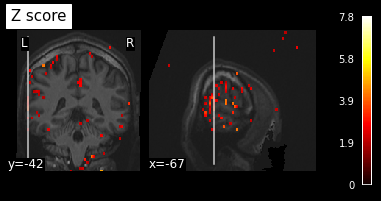

In [82]:
from nilearn.plotting import plot_stat_map, show

plot_stat_map(resampled_stat_img, bg_img=template,
              title="Z score", display_mode="yx")

show()